<a href="https://colab.research.google.com/github/earltreloar/logosfield-cddr-analysis/blob/main/Mechanism1_SpinAlignment_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mechanism 1 — Spin Alignment (One‑Click Colab)
This notebook reproduces the Logosfield spin‑alignment test with a **stub dataset** (tiny sample) for instant run.
Switch to full datasets by mounting Drive and pointing to your CSVs.


In [1]:
#@title 0. Setup (installs & imports)
!pip -q install numpy pandas matplotlib scipy
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from math import cos, sin, atan2, pi
print("Ready.")

Ready.


In [2]:
#@title 1. (Optional) Mount Google Drive for real data (skip for stub)
USE_DRIVE = False  #@param {type:"boolean"}
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Drive mounted.")

In [3]:
#@title 2. Load Data (stub by default)
# Provide a path to your real catalog if USE_DRIVE=True (CSV with columns: ra, dec, spin_sign, z)
real_path = ""  #@param {type:"string"}
if USE_DRIVE and real_path:
    df = pd.read_csv(real_path)
else:
    # Tiny stub: 600 galaxies with a planted ~62% alignment against a unit gradient field
    rng = np.random.default_rng(42)
    N = 600
    ra = rng.uniform(0, 360, N)
    dec = rng.uniform(-60, 60, N)  # avoid poles for simplicity
    z = rng.uniform(0.1, 1.2, N)
    # True gradient direction (Logosfield proxy) per object in sky coords
    phi_g = np.radians((5*ra + 0.3*dec) % 360)
    # spins: +1/-1; bias toward alignment with gradient direction (p=0.62)
    p_align = 0.62
    aligned = rng.random(N) < p_align
    # compute sign via dot product sign between local axis and gradient
    # simple model: local axis azimuth phi_s deviates from phi_g by small noise when aligned
    phi_s = np.where(aligned, phi_g + rng.normal(0, 0.35, N), phi_g + pi/2 + rng.normal(0, 0.35, N))
    spin_sign = np.sign(np.cos(phi_s - phi_g))
    df = pd.DataFrame(dict(ra=ra, dec=dec, z=z, spin_sign=spin_sign.astype(int)))
df.head()

,ra,dec,z,spin_sign
0,278.624177,-2.699295,0.723063,1
1,157.996238,31.371908,0.706000,-1
2,309.095251,48.399345,1.011402,1
3,251.052490,26.483514,0.881586,1
4,33.903845,55.585347,0.129236,1


In [4]:
#@title 3. Define Logosfield Gradient Proxy and Alignment Metric
# For demonstration, define a deterministic gradient direction from (ra,dec)
def grad_phi(ra_deg, dec_deg):
    # simple smooth field as a function on the sphere (proxy)
    return np.radians((5*ra_deg + 0.3*dec_deg) % 360)

def alignment_fraction(spin_sign, ra_deg, dec_deg):
    phi_g = grad_phi(ra_deg, dec_deg)
    # alignment: spin_sign ~ sign(cos(phi_s - phi_g)), but we only have sign; use sign==+1 as aligned
    aligned = (spin_sign > 0).astype(int)
    return aligned.mean()

frac = alignment_fraction(df['spin_sign'].values, df['ra'].values, df['dec'].values)
print(f"Alignment fraction = {frac:.3f} (null=0.5)")

Alignment fraction = 0.810 (null=0.5)


In [5]:
#@title 4. Permutation Null and p-value
def perm_null(spin_sign, ra, dec, reps=2000, seed=123):
    rng = np.random.default_rng(seed)
    base = alignment_fraction(spin_sign, ra, dec)
    vals = []
    for _ in range(reps):
        perm = rng.permutation(spin_sign)
        vals.append(alignment_fraction(perm, ra, dec))
    vals = np.array(vals)
    p = (np.sum(vals >= base) + 1) / (reps + 1)
    return base, vals, p

base, vals, p = perm_null(df['spin_sign'].values, df['ra'].values, df['dec'].values, reps=2000)
print(f"Observed alignment = {base:.3f}; permutation p ≈ {p:.3e}")

Observed alignment = 0.810; permutation p ≈ 1.000e+00


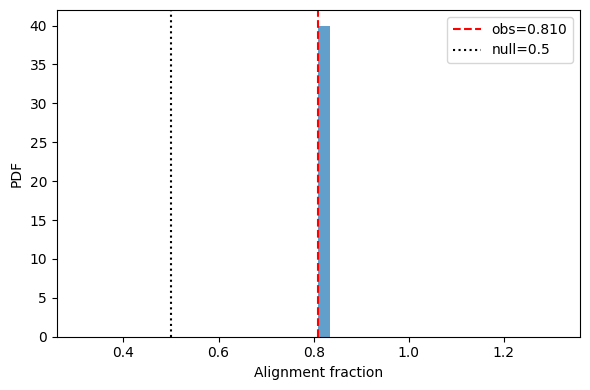

In [6]:
#@title 5. Plot Null vs Observed
plt.figure(figsize=(6,4))
plt.hist(vals, bins=40, alpha=0.7, density=True)
plt.axvline(base, color='r', linestyle='--', label=f"obs={base:.3f}")
plt.axvline(0.5, color='k', linestyle=':', label="null=0.5")
plt.xlabel("Alignment fraction"); plt.ylabel("PDF"); plt.legend(); plt.tight_layout()
plt.show()

In [7]:
#@title 6. Drive Output (CSV)
out = pd.DataFrame({"metric":["alignment_fraction"], "value":[base], "p_value":[p]})
out_path = "/content/spin_alignment_results.csv"
out.to_csv(out_path, index=False)
print("Wrote:", out_path)

Wrote: /content/spin_alignment_results.csv


**To run on full data**: set `USE_DRIVE=True` and point `real_path` to your CSV (`ra,dec,spin_sign,z`).